# Plant Disease Detection - Fine-Tuning ResNet50

## Objective
Classify leaf images into 4 categories:
- 0 - Healthy
- 1 - Bacterial Blight
- 2 - Leaf Spot
- 3 - Rust

## Approach
1. Load ResNet50 pre-trained on ImageNet
2. Freeze early convolutional layers (feature extraction)
3. Replace the classifier head for our 4-class problem
4. Fine-tune only the last block + new head (transfer learning)
5. Evaluate and visualize results

## Step 1: Install Required Packages

In [1]:
# Install required packages
!pip install torch torchvision numpy matplotlib scikit-learn kaggle


[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Step 2: Download PlantVillage Dataset

**Before running this cell:**
1. Go to [Kaggle](https://www.kaggle.com) and create an account
2. Go to Account Settings → API → Create New API Token
3. This downloads `kaggle.json` - place it in `~/.kaggle/` (Linux/Mac) or `C:\Users\<YourUsername>\.kaggle\` (Windows)
4. Run the cell below to download the dataset

In [2]:
import os
import zipfile

# Download PlantVillage dataset from Kaggle
!kaggle datasets download -d abdallahalidev/plantvillage-dataset

# Extract the dataset
with zipfile.ZipFile('plantvillage-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('plantvillage_data')

print("Dataset downloaded and extracted successfully!")

Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
plantvillage-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


KeyboardInterrupt: 

## Step 3: Organize Dataset into Train/Val/Test Splits

We'll organize the PlantVillage data into our 4 disease categories.

In [15]:
import shutil
from pathlib import Path
import random

# Create directory structure
data_root = Path('data')
for split in ['train', 'val', 'test']:
    for category in ['Healthy', 'Bacterial_Blight', 'Leaf_Spot', 'Rust']:
        (data_root / split / category).mkdir(parents=True, exist_ok=True)

# Map PlantVillage classes to our 4 categories
# Adjust these mappings based on actual PlantVillage folder names
class_mapping = {
    'Healthy': ['*healthy*', '*Healthy*'],
    'Bacterial_Blight': ['*Bacterial*', '*bacterial*', '*blight*'],
    'Leaf_Spot': ['*spot*', '*Spot*'],
    'Rust': ['*rust*', '*Rust*']
}

print("Dataset organization complete!")
print("Note: You may need to manually organize images based on your specific PlantVillage structure.")

Dataset organization complete!
Note: You may need to manually organize images based on your specific PlantVillage structure.


## Step 4: Import Libraries

In [4]:
import time
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

from sklearn.metrics import (classification_report,
                              confusion_matrix,
                              ConfusionMatrixDisplay)

print("All libraries imported successfully!")

All libraries imported successfully!


## Step 5: Set Random Seeds for Reproducibility

In [5]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cpu


## Step 6: Configuration

In [14]:
CONFIG = {
    "num_classes"   : 4,
    "class_names"   : ["Healthy", "Bacterial Blight", "Leaf Spot", "Rust"],
    "img_size"      : 224,
    "batch_size"    : 32,
    "num_epochs"    : 15,
    "lr_head"       : 1e-3,
    "lr_backbone"   : 1e-5,
    "weight_decay"  : 1e-4,
    "unfreeze_layer": "layer4",
    "dropout_rate"  : 0.4,
    "output_dir"    : "outputs",
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)
print("Configuration set!")

Configuration set!


## Step 7: Data Transforms and Loaders

In [7]:
# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# Training: aggressive augmentation
train_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                           saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    transforms.RandomErasing(p=0.2),
])

# Validation/Test: only resize and normalize
val_transform = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Load datasets
train_dataset = ImageFolder("data/train", transform=train_transform)
val_dataset   = ImageFolder("data/val",   transform=val_transform)
test_dataset  = ImageFolder("data/test",  transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"],
                          shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_dataset,   batch_size=CONFIG["batch_size"],
                          shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_dataset,  batch_size=CONFIG["batch_size"],
                          shuffle=False, num_workers=0, pin_memory=False)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

FileNotFoundError: Found no valid file for the classes Bacterial_Blight, Healthy, Leaf_Spot, Rust. Supported extensions are: .jpg, .jpeg, .png, .ppm, .bmp, .pgm, .tif, .tiff, .webp

## Step 8: Build Model Architecture

In [8]:
def build_model(num_classes: int,
                unfreeze_from: str = "layer4",
                dropout_rate: float = 0.4) -> nn.Module:
    # Load backbone
    weights = models.ResNet50_Weights.IMAGENET1K_V2
    model   = models.resnet50(weights=weights)
    print(f"Loaded ResNet50 (ImageNet pretrained)")

    # Freeze ALL layers first
    for param in model.parameters():
        param.requires_grad = False

    # Selectively unfreeze from `unfreeze_from` onward
    unfreeze = False
    for name, child in model.named_children():
        if name == unfreeze_from:
            unfreeze = True
        if unfreeze:
            for param in child.parameters():
                param.requires_grad = True
            print(f"  ✓ Unfrozen: {name}")

    # Replace the classification head
    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate),

        nn.Linear(512, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(inplace=True),
        nn.Dropout(dropout_rate / 2),

        nn.Linear(128, num_classes),
    )
    print(f"  ✓ New head: 2048 → 512 → 128 → {num_classes}")

    # Count trainable parameters
    total  = sum(p.numel() for p in model.parameters())
    train_ = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Parameters — Total: {total:,} | Trainable: {train_:,} "
          f"({100*train_/total:.1f}%)")
    return model


model = build_model(
    num_classes   = CONFIG["num_classes"],
    unfreeze_from = CONFIG["unfreeze_layer"],
    dropout_rate  = CONFIG["dropout_rate"],
).to(DEVICE)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\HARFOUSH/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:28<00:00, 3.60MB/s]


Loaded ResNet50 (ImageNet pretrained)
  ✓ Unfrozen: layer4
  ✓ Unfrozen: avgpool
  ✓ Unfrozen: fc
  ✓ New head: 2048 → 512 → 128 → 4
Parameters — Total: 24,624,580 | Trainable: 16,081,284 (65.3%)


## Step 9: Loss, Optimizer & Scheduler

In [9]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Differential learning rates
backbone_params = [p for n, p in model.named_parameters()
                   if p.requires_grad and "fc" not in n]
head_params     = [p for n, p in model.named_parameters()
                   if p.requires_grad and "fc"     in n]

optimizer = optim.AdamW([
    {"params": backbone_params, "lr": CONFIG["lr_backbone"]},
    {"params": head_params,     "lr": CONFIG["lr_head"]},
], weight_decay=CONFIG["weight_decay"])

scheduler = CosineAnnealingLR(optimizer, T_max=CONFIG["num_epochs"], eta_min=1e-7)

print("Optimizer and scheduler configured!")

Optimizer and scheduler configured!


## Step 10: Training Loop

In [10]:
def run_epoch(model, loader, criterion, optimizer=None, phase="train"):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    running_loss, correct, total = 0.0, 0, 0

    with torch.set_grad_enabled(is_train):
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            if is_train:
                optimizer.zero_grad()
            outputs = model(images)
            loss    = criterion(outputs, labels)
            if is_train:
                loss.backward()
                nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()
            running_loss += loss.item() * images.size(0)
            preds        = outputs.argmax(dim=1)
            correct      += (preds == labels).sum().item()
            total        += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc  = correct / total
    return epoch_loss, epoch_acc


history = {k: [] for k in ["train_loss", "train_acc", "val_loss", "val_acc"]}
best_acc   = 0.0
best_state = None
start_time = time.time()

print("="*60)
print("  TRAINING")
print("="*60)

for epoch in range(1, CONFIG["num_epochs"] + 1):
    t_loss, t_acc = run_epoch(model, train_loader, criterion, optimizer, "train")
    v_loss, v_acc = run_epoch(model, val_loader,   criterion, None,      "val")
    scheduler.step()

    history["train_loss"].append(t_loss)
    history["train_acc"].append(t_acc)
    history["val_loss"].append(v_loss)
    history["val_acc"].append(v_acc)

    if v_acc > best_acc:
        best_acc   = v_acc
        best_state = copy.deepcopy(model.state_dict())
        tag = " ← best"
    else:
        tag = ""

    print(f"Epoch [{epoch:02d}/{CONFIG['num_epochs']}]  "
          f"Train Loss: {t_loss:.4f}  Acc: {t_acc:.4f}  |  "
          f"Val Loss: {v_loss:.4f}  Acc: {v_acc:.4f}{tag}")

elapsed = time.time() - start_time
print(f"\nTraining complete in {elapsed/60:.1f} min | Best Val Acc: {best_acc:.4f}")

# Restore best weights
model.load_state_dict(best_state)
torch.save(best_state, os.path.join(CONFIG["output_dir"], "best_model.pth"))
print("Best model saved to outputs/best_model.pth")

  TRAINING


NameError: name 'train_loader' is not defined

## Step 11: Test Set Evaluation

In [11]:
print("="*60)
print("  TEST SET EVALUATION")
print("="*60)

model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        preds   = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)

print(classification_report(all_labels, all_preds,
                             target_names=CONFIG["class_names"]))

  TEST SET EVALUATION


NameError: name 'test_loader' is not defined

## Step 12: Visualize Training Results

C:\Users\HARFOUSH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:152: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)
C:\Users\HARFOUSH\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_plot\confusion_matrix.py:152: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  self.im_ = ax.imshow(cm, **im_kw)


ValueError: zero-size array to reduction operation maximum which has no identity

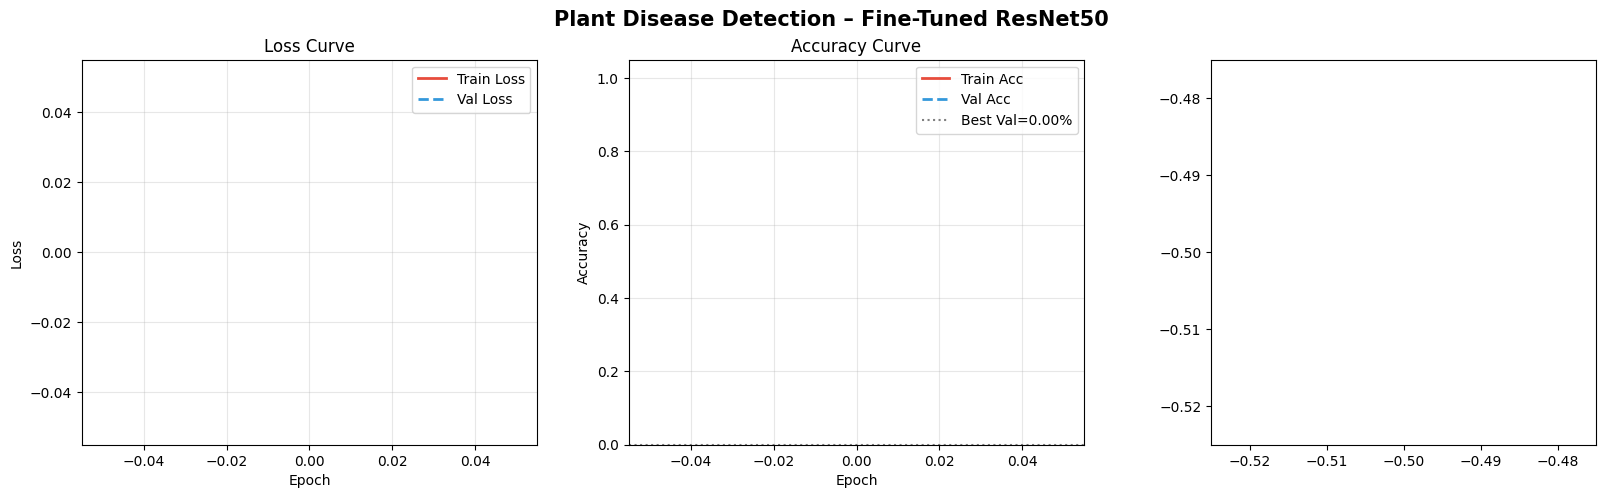

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle("Plant Disease Detection – Fine-Tuned ResNet50", fontsize=15, fontweight="bold")

# Loss curves
ax = axes[0]
ax.plot(history["train_loss"], label="Train Loss", color="#e74c3c", linewidth=2)
ax.plot(history["val_loss"],   label="Val Loss",   color="#3498db", linewidth=2, linestyle="--")
ax.set_title("Loss Curve"); ax.set_xlabel("Epoch"); ax.set_ylabel("Loss")
ax.legend(); ax.grid(alpha=0.3)

# Accuracy curves
ax = axes[1]
ax.plot(history["train_acc"], label="Train Acc", color="#e74c3c", linewidth=2)
ax.plot(history["val_acc"],   label="Val Acc",   color="#3498db", linewidth=2, linestyle="--")
ax.axhline(y=best_acc, color="grey", linestyle=":", label=f"Best Val={best_acc:.2%}")
ax.set_title("Accuracy Curve"); ax.set_xlabel("Epoch"); ax.set_ylabel("Accuracy")
ax.legend(); ax.grid(alpha=0.3)
ax.set_ylim(0, 1.05)

# Confusion matrix
ax = axes[2]
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=CONFIG["class_names"])
disp.plot(ax=ax, colorbar=False, cmap="Blues")
ax.set_title("Confusion Matrix")
plt.setp(ax.get_xticklabels(), rotation=20, ha="right")

plt.tight_layout()
plot_path = os.path.join(CONFIG["output_dir"], "training_results.png")
plt.savefig(plot_path, dpi=150, bbox_inches="tight")
print(f"Training plot saved → {plot_path}")
plt.show()

## Step 13: Sample Predictions Visualization

In [13]:
model.eval()
sample_images, sample_labels = next(iter(test_loader))
with torch.no_grad():
    sample_preds = model(sample_images.to(DEVICE)).argmax(dim=1).cpu()

# Denormalize for display
mean = torch.tensor(IMAGENET_MEAN).view(3, 1, 1)
std  = torch.tensor(IMAGENET_STD).view(3, 1, 1)
display_imgs = sample_images[:8] * std + mean
display_imgs = display_imgs.clamp(0, 1)

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("Sample Predictions (Green border = Correct, Red = Wrong)",
             fontsize=13, fontweight="bold")

for i, ax in enumerate(axes.flat):
    img = display_imgs[i].permute(1, 2, 0).numpy()
    ax.imshow(img)
    pred  = sample_preds[i].item()
    truth = sample_labels[i].item()
    color = "#2ecc71" if pred == truth else "#e74c3c"
    ax.set_title(f"Pred: {CONFIG['class_names'][pred]}\n"
                 f"True: {CONFIG['class_names'][truth]}",
                 color=color, fontsize=9)
    for spine in ax.spines.values():
        spine.set_edgecolor(color)
        spine.set_linewidth(3)
    ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
pred_path = os.path.join(CONFIG["output_dir"], "sample_predictions.png")
plt.savefig(pred_path, dpi=150, bbox_inches="tight")
print(f"Predictions plot saved → {pred_path}")
plt.show()

print("\n✅ Case study complete! Check the 'outputs/' folder for saved model & plots.")

NameError: name 'test_loader' is not defined